In [1]:
import numpy as np
import pandas as pd


from NPIR import NPIR

from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn import metrics

import matplotlib.pyplot as plt

import datetime
import warnings
from collections import Counter as Cs
from timeit import default_timer as timer
from datetime import timedelta


import findspark
findspark.init()

########
from numpy import array
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
########

from pyspark import SparkContext
from operator import *
from pyspark import StorageLevel
from pyspark.sql.types import IntegerType, FloatType, BooleanType, StringType, StructType,\
StructField,ArrayType, DataType
from pyspark.sql.functions import udf, log, rand, monotonically_increasing_id, col, broadcast,\
greatest, desc, asc, row_number, avg, mean, least, struct, lit, sequence, sum
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, SQLContext, Window, Row, DataFrame
from pyspark import SparkConf

In [2]:
spark = SparkSession.builder.master("local[*]").config("spark.sql.broadcastTimeout", "30000s").\
config("spark.network.timeout","30000s").config("spark.executor.heartbeatInterval","12000000ms").\
config("spark.storage.blockManagerSlaveTimeoutMs","12000001ms").config("spark.driver.maxResultSize","12g").\
config("spark.default.parallelism", "100").config("spark.memory.offHeap.enabled","true").\
config("spark.memory.offHeap.size", "25g").appName("NPIR_Parallel").getOrCreate()

In [3]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [90]:
# x1,y1 = make_blobs(n_samples=100000, centers=3, n_features=2,
#                 random_state=1)
# data = pd.DataFrame(x1)
# data['label'] = y1
# data.head()

,0,1,label
0,-7.002087,-8.907138,2
1,-3.924871,4.641454,0
2,-1.016122,3.565642,0
3,-1.845549,4.095494,0
4,-1.106740,4.322652,0


In [91]:
# data = shuffle(data)
# data.head()

,0,1,label
44991,-6.387419,-9.187990,2
66316,-8.005179,-7.220052,2
79257,-9.697294,-3.522539,1
84149,-1.279403,2.598460,0
55802,-8.563066,-2.936928,1


In [92]:
# data.to_csv('blobs2.csv', index=False)

In [4]:
#read csv
data_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('blobs2.csv')
data_spark_df.show()

+-------------------+-------------------+-----+
|                  0|                  1|label|
+-------------------+-------------------+-----+
| -6.387419071034336| -9.187990381898826|    2|
| -8.005178595989918|-7.2200516657858405|    2|
| -9.697294242434808|-3.5225390707496924|    1|
| -1.279403340386375| 2.5984596752053735|    0|
| -8.563066013141189|-2.9369284461861698|    1|
| -9.874034130661965| -6.478907984278638|    1|
| 0.6679093864997019| 3.9098652430890275|    0|
| -8.825110289032803| -3.781733114789269|    1|
| -8.995818953272746| -8.344036741165064|    2|
| -8.547061454068198|  -4.30459999107529|    1|
| -6.033181639480226| -8.561204983658731|    2|
| -7.465835003635627| -9.686186295830733|    2|
| -5.713231338882324| -7.549527445975742|    2|
|-10.870568282036668| -4.963228932719754|    1|
| -6.724671113424062| -7.772678812956407|    2|
| -10.33555446704167| -4.229877104261299|    1|
| -8.973272284198908|-4.1611574672378655|    1|
| -6.926612635252511| -8.131169868850513

In [5]:
data_spark_df.describe()

DataFrame[summary: string, 0: string, 1: string, label: string]

In [6]:
data_spark_df.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)
 |-- label: string (nullable = true)



In [7]:
data_spark_df = data_spark_df.select('0', '1')

In [8]:
new_name = ['first', 'second']
data_spark_rdd = data_spark_df.toDF(*new_name).rdd.filter(lambda x:x)
data_spark_df = data_spark_df.toDF(*new_name)

In [9]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.conf.set('spark.jars.packages','com.databricks:spark-cav_2.11')
spark.conf.set("spark.sql.parquet.compression.codec","gzip")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "False")
sqlContext.setConf("spark.sql.shuffle.partitions", "100")

In [10]:
# x1,y1 = make_blobs(n_samples=100, centers=3, n_features=2,
#                 random_state=1)

In [11]:
points = data_spark_df.count()
points

100000

In [12]:
100000/400

250.0

In [13]:
#IR: The indexing ratio to be used for generating the maximum index
IR = 0.2
#The number of iteration i
i = 10
k = 3 #k: Number of clusters
# count = Cs()
chunk = 400


In [103]:
# start = timer()
# kmeans = KMeans(n_clusters=k, random_state=0).fit(x)
# end = timer()
# print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [14]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

data_spark = data_spark_df.withColumn('index_column_name', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
# data_spark.show()

In [15]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [16]:
data_spark.columns

['first', 'second', 'index_column_name']

In [17]:
leaderheadr = ['chunkLabel', 'old label', 'count']
leaderheadr.extend([str(x) for x in range(1, len(data_spark.columns))])
leaderheadr = tuple(leaderheadr)
leaderheadr

('chunkLabel', 'old label', 'count', '1', '2')

In [18]:
labelsheader = ('chunkLabel', 'label')
labelsheader

('chunkLabel', 'label')

In [ ]:
start = timer()


labels = sqlContext.createDataFrame([np.full(len(labelsheader), np.nan).tolist()],labelsheader)
labels = labels.na.drop()

leaders = sqlContext.createDataFrame([np.full(len(leaderheadr), np.nan).tolist()],leaderheadr)
leaders = leaders.na.drop()

ii = 0
for z in range(0, points, chunk):
    j = z + chunk
    data = data_spark.where(col("index_column_name").between(z, j-1)).toPandas()
    data.drop("index_column_name",axis=1,inplace=True)
    data = data.astype(float)
    from NPIR import NPIR
    label = NPIR(data.values,k,IR,i)
    data['labels'] = label
    
    # Adding to pyspard label
    chunklabel = np.full(len(label), ii).tolist()
    labelDF = [(x, y) for x, y in zip(chunklabel, label)]
    labelsDF = sqlContext.createDataFrame(labelDF,labelsheader)
    labels = unionAll(labels, labelsDF)

    leader = []
    f = list(Cs(label))
    f.sort()
    for i in f:
        leader.append([round(np.mean(z), 4) for z in data[data['labels']==i].values[:,:-1].T])
    del data
    del NPIR
    
    # Adding to pyspark leaders
    for x in range(len(leader)):
        x1 = [ii, x, Cs(label)[x]]
        x1.extend(leader[x])
        leader[x] = x1
    leaderDF = sqlContext.createDataFrame(leader,leaderheadr)
    leaders = unionAll(leaders, leaderDF)
    ii += 1
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [ ]:
# Cs(label)

In [ ]:
# leaders.show()

In [ ]:
# # Load and parse the data
# data = sc.textFile("data/mllib/kmeans_data.txt")
# parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))
parsedData = leaders.select(['1', '2']).rdd.map(list)

start = timer()
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, k, maxIterations=20, initializationMode="random")
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [ ]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
# def error(point):
#     center = clusters.centers[clusters.predict(point)]
#     return sqrt(sum([x**2 for x in (point - center)]))

# WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
# print("Within Set Sum of Squared Error = " + str(WSSSE))

In [ ]:
# clusters.centers

In [ ]:
# # Save and load model
# clusters.save(sc, "KMeansModel")
# sameModel = KMeansModel.load(sc, "KMeansModel")

In [ ]:
# from numpy import array
# from math import sqrt

# from pyspark.mllib.clustering import KMeans, KMeansModel

# # Load and parse the data
# data = sc.textFile("data/mllib/kmeans_data.txt")
# parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# # Build the model (cluster the data)
# clusters = KMeans.train(parsedData, 2, maxIterations=10, initializationMode="random")

# # Evaluate clustering by computing Within Set Sum of Squared Errors
# def error(point):
#     center = clusters.centers[clusters.predict(point)]
#     return sqrt(sum([x**2 for x in (point - center)]))

# WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
# print("Within Set Sum of Squared Error = " + str(WSSSE))

# # Save and load model
# clusters.save(sc, "target/org/apache/spark/PythonKMeansExample/KMeansModel")
# sameModel = KMeansModel.load(sc, "target/org/apache/spark/PythonKMeansExample/KMeansModel")

# c1x c2y c3z
# /
# (c1 + c2 + c3)

# sum = (c1 + c2 + c3)
# leader[c1/sum*x +c2/sum*y+ c3/sum*z]


In [ ]:
# labels.show()

In [ ]:
# leaders = leaders.select(['chunkLabel','old label','1','2'])

In [ ]:
# data_spark = leaders.withColumn("first_numeric", leaders["1"].cast(FloatType()))
# data_spark = data_spark.withColumn("second_numeric", data_spark["2"].cast(FloatType()))
# data_spark = data_spark.drop('1').drop('2').drop('chunkLabel').drop('old label')
# # #### Compute weighted average
# # count = data_spark.select('count')
# # ####

# data_spark = data_spark.drop('1').drop('2').drop('chunkLabel').drop('old label').drop('count')
# data_spark

In [ ]:
# count = count.withColumn('Cindex', row_number().\
#                                           over(Window.orderBy(monotonically_increasing_id())) - 1)
# count

In [ ]:
# def MyCheckUpdate(a, b, c, d):
#     a = float(a)
#     b = float(b)
#     c = float(c)
#     d = float(d)
#     res = (a-c) + (b-d)
#     if res == 0:
#         return 1.0
#     return 0.0

# check_centroid = udf(lambda x,y,z,r: MyCheckUpdate(x,y,z,r), FloatType())

# def squaree1(c,u,f,g):
#     c = float(c)
#     u = float(u)
#     f = float(f)
#     g = float(g)
#     array1 = np.array([c,u])
#     array2 = np.array([f,g])
#     dist = np.linalg.norm(array1-array2)
#     dist = dist.item()
#     return dist

# squaree_spark1 = udf(lambda x,y,z,r: squaree1(x,y,z,r), FloatType())
# sqlContext.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

In [ ]:
# df_centroid = data_spark.sample(False, 0.4,seed = 0).limit(1).cache()

# new_name = ['x','y']
# df_centroid = df_centroid.toDF(*new_name)

# #just for first round
# #first time
# i = 0
# data_cent = data_spark.join(broadcast(df_centroid))
# data_cent1 = data_cent.withColumn(str(i),squaree_spark1(data_cent.columns[0],data_cent.columns[1],
#                                               data_cent.columns[2*i+2],data_cent.columns[2*i+3]))
# data_cent2 = data_cent1.drop(data_cent1.columns[i+2]).drop(data_cent1.columns[i+3])
# data_cent3 = data_cent2.withColumn('mindist',col(str(i)))
# data_cent4 = data_cent3.withColumn('mindist1',least(data_cent3.columns[i+2], col('mindist')))
# data_cent4 = data_cent4.drop('mindist')
# data_cent5 = data_cent4.withColumnRenamed('mindist1','mindist')
# next_selected = data_cent5.orderBy(desc('mindist')).limit(1).select(data_cent5.columns[0:2])#1:3

# df_centroid = df_centroid.union(next_selected)
# u = [str(i)+'x',str(i)+'y']
# next_selected = next_selected.toDF(*u)
# def initial_centroids(next_selected,data_cent_5_persist, i):
#     data_cent6 = data_cent_5_persist.join(broadcast(next_selected))
#     data_cent6 = data_cent6.withColumn(str(i),squaree_spark1(data_cent6.columns[0],data_cent6.columns[1],
#                                              data_cent6.columns[i+3],data_cent6.columns[i+4]))#+4 +5
#     data_cent6 = data_cent6.drop(data_cent6.columns[i+3]).drop(data_cent6.columns[i+4])#+4 +5
#     data_cent6 = data_cent6.withColumn('mindist1',least(data_cent6.columns[i+3], col('mindist')))#4
#     data_cent6 = data_cent6.drop('mindist')
#     data_cent6 = data_cent6.withColumnRenamed('mindist1','mindist')
#     next_cent = data_cent6.orderBy(desc('mindist')).limit(1).select(data_cent6.columns[0:2])#1:3
#     return next_cent,data_cent6


# data_cent_5_persist = data_cent5.persist(StorageLevel.MEMORY_ONLY_2)


# # start = timer()
# for i in range(1,k-1):
#     next_selected, data_cent_5_persist = initial_centroids(next_selected,data_cent_5_persist, i)
#     u = [str(i)+'x',str(i)+'y']
#     next_selected = next_selected.toDF(*u)

# # end = timer()
# # print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))



# i= k-1
# data_cent11 = data_cent_5_persist.join(broadcast(next_selected))
# data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],data_cent11.columns[1],\
#                                                            data_cent11.columns[k+2],data_cent11.columns[k+3]))
# data_cent11 = data_cent11.drop('mindist').drop(data_cent11.columns[k+2]).drop(data_cent11.columns[k+3])


# def FindMinCOl( *row_list):
#     ind = row_list.index(min(*row_list))
#     return int(ind)

# find_min_val_name = udf(FindMinCOl, IntegerType())
# data_cent14 = data_cent11.withColumn('defined_cluster', find_min_val_name(*data_cent11.columns[2:3+k]))
# data_cent14 = data_cent14.select('first_numeric','second_numeric','defined_cluster')


# # #### Compute weighted average
# # data_cent14 = data_cent14.withColumn('index', row_number().\
# #                                           over(Window.orderBy(monotonically_increasing_id())) - 1)

# # data_cent14 = (data_cent14.join(count, (col('Cindex') == col('index')),\
# #           "inner")).drop('index').drop('Cindex')

# # for c in data_spark.columns:
# #     data_cent14 = data_cent14.withColumn(c+'*',col(c)*col('count') )
# #     data_cent14 = data_cent14.drop(c).withColumnRenamed(c+'*', c)

# # new_centroid = data_cent14.groupBy('defined_cluster').sum('first_numeric', 'second_numeric').\
# # withColumnRenamed('defined_cluster', 'defined_cluster*')

# # new_centroid1 = data_cent14.groupBy('defined_cluster').sum('count')
# # new_centroid = (new_centroid1.join(new_centroid, (col('defined_cluster') == col('defined_cluster*')),\
# #           "inner")).drop('defined_cluster*')
# # ####
# # for c in new_centroid.columns:
# #     new_centroid = new_centroid.withColumnRenamed(c, c.replace('sum(', '').replace(')', ''))

# # for c in new_centroid.columns[2:]:
# #     new_centroid = new_centroid.withColumn(c, col(c) / col('sum(count)'))

# # new_centroid = new_centroid.drop('sum(count)')
# # ####
# new_centroid = data_cent14.groupBy('defined_cluster').avg('first_numeric', 'second_numeric')


In [ ]:

# spark.sparkContext.getConf().getAll()
# spark.conf.get("spark.sql.shuffle.partitions")
# def UpdateCentroid(x):
#     data_cent_join1 = data_spark.join(broadcast(x))
#     data_cent_join2 = data_cent_join1.withColumn('dist',squaree_spark1(data_cent_join1.columns[0],
#                                                                  data_cent_join1.columns[1],
#                                        data_cent_join1.columns[3],data_cent_join1.columns[4]))#3 4
#     w = Window.partitionBy(data_cent_join2.columns[1])
#     next_centroid = data_cent_join2.withColumn('mindist', F.min('dist').over(w)).\
#     filter(col('dist') == col('mindist')).drop('dist')

# #     #### Compute weighted average
# #     data_cent14 = next_centroid.withColumn('index', row_number().\
# #                                               over(Window.orderBy(monotonically_increasing_id())) - 1)

# #     data_cent14 = (data_cent14.join(count, (col('Cindex') == col('index')),\
# #               "inner")).drop('index').drop('Cindex')

# #     for c in data_spark.columns:
# #         data_cent14 = data_cent14.withColumn(c+'*',col(c)*col('count') )
# #         data_cent14 = data_cent14.drop(c).withColumnRenamed(c+'*', c)

# #     new_centroid = data_cent14.groupBy('defined_cluster').sum('first_numeric', 'second_numeric').\
# #     withColumnRenamed('defined_cluster', 'defined_cluster*')

# #     new_centroid1 = data_cent14.groupBy('defined_cluster').sum('count')
# #     new_centroid = (new_centroid1.join(new_centroid, (col('defined_cluster') == col('defined_cluster*')),\
# #               "inner")).drop('defined_cluster*')


# #     for c in new_centroid.columns[2:]:
# #         new_centroid = new_centroid.withColumn(c, col(c) / col('sum(count)'))

# #     update_new_centroid = new_centroid.drop('sum(count)')
# #     ############
#     update_new_centroid = next_centroid.groupBy('defined_cluster').avg('first_numeric', 'second_numeric')

#     return update_new_centroid, next_centroid

# new_centroid_persist = new_centroid.persist(StorageLevel.MEMORY_AND_DISK)

# # start = timer()

# for i in range(20):
#     new_centroid_persist, final_data = UpdateCentroid(new_centroid_persist)

# # end = timer()


# final_data = final_data.withColumnRenamed('avg(first_numeric)','cent_x').\
# withColumnRenamed('avg(second_numeric)','cent_y')

In [ ]:
# new_centroid_persist.show()

In [ ]:
# type(new_centroid_persist)


In [ ]:
# data_cent11 = sc.parallelize([])
start = timer()

spark_cluster_centroid = sqlContext.createDataFrame(([c.tolist() for c in clusters.centers]),\
                                                    ['cent_x', 'cent_y'])
spark_cluster_centroid = spark_cluster_centroid.withColumn('defined_cluster', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
data_cent11 = 0
for i in range(k):
    u = [ str(i)+'x',str(i)+'y']
    next_selected = spark_cluster_centroid.filter(col('defined_cluster') == str(i)).\
    drop('defined_cluster').toDF(*u)
    if i == 0:
        data_cent11 = data_spark_df.join(broadcast(next_selected))
#         print(data_cent.count())
        
        data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],\
                            data_cent11.columns[1],data_cent11.columns[i+2],data_cent11.columns[i+3]))
#         data_cent11.show()
        data_cent11 = data_cent11.drop(data_cent11.columns[i+2]).drop(data_cent11.columns[i+3])
#         data_cent11.show()
        data_cent11 = data_cent11.withColumn('mindist',col(str(i)))
#         data_cent11.show()
        data_cent11 = data_cent11.withColumn('mindist1',least(data_cent11.columns[i+2], col('mindist')))
#         data_cent11.show()
        data_cent11 = data_cent11.drop('mindist')
        data_cent11 = data_cent11.withColumnRenamed('mindist1','mindist')
    elif i > 0:
        data_cent11 = data_cent11.join(broadcast(next_selected))
#         data_cent11.show()
        data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],\
                                    data_cent11.columns[1], data_cent11.columns[i+3],data_cent11.columns[i+4]))
#         data_cent11.show()
        data_cent11 = data_cent11.drop(u[0]).drop(u[1])
#         data_cent11.show()
        data_cent11 = data_cent11.withColumn('mindist1',least(data_cent11.columns[i+3], col('mindist')))#4
#         data_cent11.show()
        data_cent11 = data_cent11.drop('mindist')
        data_cent11 = data_cent11.withColumnRenamed('mindist1','mindist')
#         next_cent = data_cent11.orderBy(desc('mindist')).limit(1).select(data_cent11.\
#                                                                          columns[:len(data_spark_df.columns)-1])#1:3
data_cent11 = data_cent11.drop('mindist')

# data_cent11.show()

In [ ]:
def FindMinCOl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)
find_min_val_name = udf(FindMinCOl, IntegerType())

data_cent11 = data_cent11.withColumn('defined_cluster', find_min_val_name(*data_cent11.columns[2:3+k]))
data_cent11 = data_cent11.select('first','second','defined_cluster')

In [ ]:
d = data_cent11.toPandas()

end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [133]:
# final_data = new_centroid_persist.withColumnRenamed('avg(first_numeric)','cent_x').\
# withColumnRenamed('avg(second_numeric)','cent_y')

In [134]:
# final_data = fspark_cluster_centroid.withColumn('index', row_number().\
#                                           over(Window.orderBy(monotonically_increasing_id())) - 1).\
# drop('mindist').drop('second_numeric').drop('first_numeric')

In [89]:
# final_data.show()

In [136]:
# leaders = leaders.withColumn('index_column_name', row_number().\
#                                           over(Window.orderBy(monotonically_increasing_id())) - 1)
# # final_data.show()

In [145]:
# leaders1 = leaders.drop('count')
# leaders1.show()

+----------+---------+-------+-------+-----------------+
|chunkLabel|old label|      1|      2|index_column_name|
+----------+---------+-------+-------+-----------------+
|       0.0|      0.0|-5.3511|-9.9046|                0|
|       0.0|      1.0| 7.5163| 0.7371|                1|
|       0.0|      2.0| 7.4675| 9.3241|                2|
|       1.0|      0.0|-5.2052|-9.6946|                3|
|       1.0|      1.0| 7.5018|  9.535|                4|
|       1.0|      2.0| 7.3172|  0.689|                5|
|       2.0|      0.0| 7.4575| 9.5226|                6|
|       2.0|      1.0|-5.2877| -9.868|                7|
|       2.0|      2.0| 7.3482| 0.5407|                8|
|       3.0|      0.0|-5.3098|-9.6673|                9|
|       3.0|      1.0| 7.4462| 9.2842|               10|
|       3.0|      2.0| 7.5647| 0.5932|               11|
|       4.0|      0.0| 7.5252| 9.4987|               12|
|       4.0|      1.0| 7.3161| 0.7877|               13|
|       4.0|      2.0|-5.4577|-

In [143]:
# lead_final = (leaders1
#     .join(final_data, (col('index_column_name') == col('index')), "inner")).drop('1').drop('2').\
#     drop('index_column_name').drop('index')
# #     .withColumnRenamed("defined_cluster", "new label"))
# lead_final.show()

+----------+---------+-----+---------------+
|chunkLabel|old label|count|defined_cluster|
+----------+---------+-----+---------------+
|       0.0|      0.0| 83.0|              0|
|       0.0|      1.0|115.0|              1|
|       0.0|      2.0|102.0|              2|
+----------+---------+-----+---------------+



In [138]:
# lead_final = lead_final.withColumnRenamed('chunkLabel','chunk')

In [139]:
# label_lead_final = (labels
#     .join(lead_final,  ((col('label') == col('old label')) & (col('chunkLabel') == col('chunk'))),\
#           "left")).drop('chunkLabel').drop('label').drop('old label').drop('chunk')

# # label_lead_final.show()

In [140]:
# d = label_lead_final.toPandas()
# d

# Primariy Data: Max( o(n \* p), o(n \* n))


# means:  uper(n / chunks) \* k \* p

## (1 * 1) > 1 / chunks * k * 1 => chunks > k

# labels: n

In [90]:
# start = timer()

# labelsPred = NPIR(x,k,IR,i)
# # labelsPred1 = NPIR(x1,k,IR,i)
# end = timer()
# print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))
# labelsPred 

In [91]:
# xf = pd.DataFrame(x)
# xf['label'] = labelsPred

# xf1 = pd.DataFrame(x1)
# xf1['label'] = labelsPred1


In [92]:
# Cs(labelsPred)

In [93]:
# leader = []
# f = list(Cs(labelsPred))
# f.sort()
# for i in f:
#     leader.append([np.mean(z) for z in xf[xf['label']==i].values[:,:-1].T])
# leader

In [94]:
# leader1 = []
# f = list(Cs(labelsPred1))
# f.sort()
# for i in f:
#     leader1.append([np.mean(z) for z in xf1[xf1['label']==i].values[:,:-2].T])
# leader1

In [95]:
# xf1[xf1['label']==0].values[:,:]

# 1 2 3 4 5 6 7 
# 1 2 3 4
# 1 2
# 1

# 2**b

# a \* t(NPIR(n / a)) + (a - 1) \* t(NPIR(k)) ><? t(NPIR(n))

In [96]:
# centers = leader.copy()
# centers.extend(leader1)
# centers

In [97]:
# newlabel = NPIR(centers,k,IR,i)
# newlabel

In [98]:
# newlabel[:k][2]

In [99]:
# newleader =[]
# for i in range(k):

In [100]:
# xf['newlabel'] = np.full(len(xf), np.nan)
# xf1['newlabel'] =np.full(len(xf1), np.nan)
# # f = list(Cs(labelsPred))
# # f.sort()
# for i in range(k):
#     xf.loc[xf['label'] == i,'newlabel'] = newlabel[:k][i]

# # f = list(Cs(labelsPred1))
# # f.sort()
# for i in range(k):
#     xf1.loc[xf1['label'] == i,'newlabel'] = newlabel[-k:][i]
# merged_data = xf.append(xf1)
# merged_data['label'] = merged_data['newlabel']
# merged_data.drop(['newlabel'], inplace =True,axis=1)
# merged_data.reset_index(inplace=True)
# merged_data.drop(['index'], inplace =True,axis=1)
# merged_data

In [101]:
# xf = merged_data.copy()
# labelsPred = merged_data['label']
# xf

In [102]:
# tStart = datetime.datetime.now()

In [81]:
data = pd.read_csv('blobs1.csv')
data.head()

,0,1,label
0,-7.166263,-8.485439,2
1,-2.255228,4.097369,0
2,-5.657472,-8.239242,2
3,-1.775545,4.231031,0
4,-11.043247,-3.598064,1


In [82]:
data = data[['0','1','label']]


In [83]:
# d = d1.copy()

In [84]:
data['new'] = d['defined_cluster'].astype('int8')
# data['new'] = NPIR(pd.read_csv('blobs.csv', header=None).iloc[:,:2].values,k,IR,i)
data.head()

,0,1,label,new
0,-7.166263,-8.485439,2,1
1,-2.255228,4.097369,0,2
2,-5.657472,-8.239242,2,1
3,-1.775545,4.231031,0,2
4,-11.043247,-3.598064,1,0


In [85]:
y = data['label']
labelsPred = data['new']
list(labelsPred)

[1,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 0,


In [86]:
x = data[['0','1']].values
x.shape

(1000, 2)

In [87]:
#printing results
print('labels:')
# print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))

labels:
Measures:
HS: 0.9621168996417789
CS: 0.96232999482604
VM: 0.9622234354358292
AMI: 0.9621543457563968
ARI: 0.9733414081860785


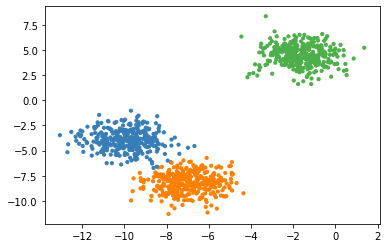

In [88]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[labelsPred.tolist()])
plt.show()
# plt.clf()

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x1[:, 0], x1[:, 1], s=10, color=colors[labelsPred1.tolist()])
plt.show()
# plt.clf()

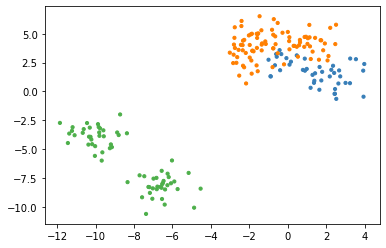

In [21]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(merged_data.iloc[:, 0].values, merged_data.iloc[:, 1].values, s=10, color=colors[merged_data['label'].astype(int).tolist()])
plt.show()
# plt.clf()

In [28]:
# [labelsPred1.tolist()]